# Quantization Aware Training

This notebook shows how to use [brevitas](https://github.com/Xilinx/brevitas) to implement 
a small fully connected neural network that uses Quantization Aware Training (QAT). Since FHE
contraints force neural networks to be quantized to very low bitwidths (2-3 bit weights and 
activations), it is important to take quantization into account during training in order to obtain good
accuracy.

We show here how to implement, train and compile the network to FHE and, then, we compare it to a non QAT version.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import torch
from concrete.numpy.compilation.configuration import Configuration
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from concrete.ml.torch.compile import compile_torch_model

### Data set generation

We generate a simple checkerboard pattern, which is a common benchmark for non-linear classifiers. 

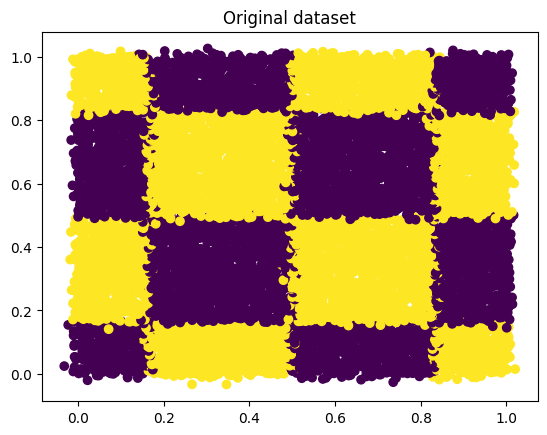

In [2]:
N_FEAT = 2
N_SIDE = 100
N_EXAMPLE_TOTAL = N_SIDE * N_SIDE
N_TEST = 500
CLUSTERS = 3

# Generate the grid points and put them in a 2 column list of X,Y coordinates
xx, yy = numpy.meshgrid(numpy.linspace(0, 1, N_SIDE), numpy.linspace(0, 1, N_SIDE))
X = numpy.c_[numpy.ravel(xx), numpy.ravel(yy)]

# Generate the labels, using the XOR function to produce the checkerboard
y = (numpy.rint(xx * CLUSTERS).astype(numpy.int64) % 2) ^ (
    (numpy.rint(yy * CLUSTERS).astype(numpy.int64) % 2)
)
y = y.ravel()

# Add some noise to the data
X += numpy.random.randn(X.shape[0], X.shape[1]) * 0.01

# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Original dataset")
plt.show()

# And, finally, split it into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=N_TEST / N_EXAMPLE_TOTAL, random_state=42
)

### Training loop

In this example we implement a classic simple torch training loop that can be used for both QAT and 
regular float32 networks.

In [3]:
def train(torch_model, X_train, X_test, y_train, y_test, optimizer, epochs=10):
    X_train = torch.tensor(X_train).float()
    tX_test = torch.tensor(X_test).float()
    y_train = torch.tensor(y_train)

    train_loader = DataLoader(TensorDataset(X_train, y_train))
    torch_model.train()
    for epoch in range(epochs):
        tot_loss = 0
        y_pred_all = []
        for X_batch, y_batch in train_loader:
            # Forward pass
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = torch_model(X_batch)
            y_pred_all.append(y_pred.argmax(1).detach().cpu().numpy())

            # Compute loss
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            tot_loss += loss.cpu().item()

        # Print epoch number, loss and accuracy
        y_pred_all = numpy.concatenate(y_pred_all)
        accuracy = numpy.mean(y_pred_all == y_train.numpy())
        print(
            f"Epoch: {epoch:02} | Loss: {tot_loss / y_train.size()[0]:.4f} |"
            f" Train Accuracy: {100*accuracy:.2f}%"
        )

    # Compute test accuracy once training is done
    torch_model.eval()
    fp32_pred = torch_model(tX_test).argmax(1).float().detach().numpy()
    accuracy = numpy.mean(fp32_pred == y_test)
    print(f"\nTest Accuracy Fp32: {accuracy*100:.2f}%")

    return accuracy

### Conversion to FHE and compilation

In this example we build a neural network that is compatible with FHE, by using the Virtual Library check compatibility and accuracy.
The Virtual Library (VL) executes the circuit in the clear, all the while ensuring equivalence to FHE computation. Using the Virtual Library 
is much faster and thus very useful in debugging. 

Once the network is trained to the required accuracy
we can compile to FHE and deploy the encrypted circuit. Once compiled to FHE, we are not using the Virtual Library anymore, as the VL is a tool that helps only during network development to debug FHE constraint compliance and to check accuracy.

Please note the configuration for the number of bits during import:

`n_bits = {"net_inputs": 7, "op_inputs": 3, "op_weights": 3, "net_outputs": 7}`

The network inputs and outputs are quantized to 7 bits. The weights and activations are imported already quantized to 3 bits.

In [4]:
def compile_and_test(torch_model, X_train, X_test, y_test, is_qat=False):

    # Compile with the Virtual Library
    COMPIL_CONFIG_VL = Configuration(
        dump_artifacts_on_unexpected_failures=False,
        enable_unsafe_features=True,  # This is for our tests in Virtual Library only
    )
    quantized_numpy_module = compile_torch_model(
        torch_model,  # our model
        X_train,  # a representative inputset to be used for both quantization and compilation
        n_bits={"net_inputs": 7, "op_inputs": 3, "op_weights": 3, "net_outputs": 7},
        import_qat=is_qat,  # signal to the conversion function whether the network is QAT
        use_virtual_lib=True,
        configuration=COMPIL_CONFIG_VL,
    )

    # Check that the network is compatible with FHE constraints
    bitwidth = quantized_numpy_module.forward_fhe.graph.maximum_integer_bit_width()
    print(
        f"Max bitwidth: {bitwidth} bits" + " -> it works in FHE!!"
        if bitwidth <= 8
        else " too high for FHE computation"
    )

    # Execute prediction with the Virtual Library
    # (not encrypted but fast, and results are equivalent)

    clear_prediction = numpy.zeros_like(y_test)
    for idx, x in enumerate(X_test):
        x_q = quantized_numpy_module.quantize_input(numpy.expand_dims(x, 0))
        circuit_prediction = quantized_numpy_module.forward_fhe.encrypt_run_decrypt(x_q)
        clear_prediction[idx] = quantized_numpy_module.dequantize_output(circuit_prediction).argmax(
            axis=1
        )

    # Compute accuracy
    accuracy = numpy.mean(clear_prediction == y_test) * 100
    print(f"Test Quantized Accuracy: {accuracy:.2f}%")
    return bitwidth, accuracy, clear_prediction

### Quantization options

With brevitas we have a large palette of quantization parameters that can be combined. Not all configurations
are useful for FHE compatible neural networks. Here we define the options for quantizing weights and activations.

For both weights and activations we want a quantization which has a zero zero-point. This setting
allows to keep the accumulator size low while also speeding up computation.  Please refer to the 
[quantization documentation](../quantization.md) for details about the usage of the zero-point. 

With QAT we can force the zero-point to be zero during training, and, thus, learn weights that work 
well in this setting.

In [5]:
import brevitas.nn as qnn
from brevitas.core.bit_width import BitWidthImplType
from brevitas.core.quant import QuantType
from brevitas.core.restrict_val import FloatToIntImplType, RestrictValueType
from brevitas.core.scaling import ScalingImplType
from brevitas.core.zero_point import ZeroZeroPoint
from brevitas.inject import ExtendedInjector
from brevitas.quant.solver import ActQuantSolver, WeightQuantSolver
from dependencies import value
from torch.nn.utils import prune


class CommonQuant(ExtendedInjector):
    bit_width_impl_type = BitWidthImplType.CONST
    scaling_impl_type = ScalingImplType.CONST
    restrict_scaling_type = RestrictValueType.FP
    zero_point_impl = ZeroZeroPoint
    float_to_int_impl_type = FloatToIntImplType.ROUND
    scaling_per_output_channel = False
    narrow_range = True
    signed = True

    @value
    def quant_type(bit_width):  # pylint: disable=no-self-argument
        if bit_width is None:
            return QuantType.FP
        if bit_width == 1:
            return QuantType.BINARY
        return QuantType.INT


class CommonWeightQuant(CommonQuant, WeightQuantSolver):  # pylint: disable=too-many-ancestors
    scaling_const = 1.0
    signed = True


class CommonActQuant(CommonQuant, ActQuantSolver):  # pylint: disable=too-many-ancestors
    min_val = -1.0
    max_val = 1.0

### QAT fully connected NN implementation

We now define the quantization aware training-enabled network. Note that the structure is very simple,
with only 2 hidden layers and few neurons. We also use pruning to ensure that many neurons are disabled
and keep the accumulator size down. Please refer to the [FHE-friendly model tutorial](../fhe_friendly_models.md)
for details about the advantages of QAT and pruning.

In [6]:
class QATPrunedSimpleNet(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()

        n_bits = 3
        self.quant_inp = qnn.QuantIdentity(
            act_quant=CommonActQuant,
            bit_width=n_bits,
            return_quant_tensor=True,
        )

        self.fc1 = qnn.QuantLinear(
            N_FEAT,
            n_hidden,
            True,
            weight_quant=CommonWeightQuant,
            weight_bit_width=n_bits,
            bias_quant=None,
        )

        self.q1 = qnn.QuantIdentity(
            act_quant=CommonActQuant, bit_width=n_bits, return_quant_tensor=True
        )

        self.fc2 = qnn.QuantLinear(
            n_hidden,
            n_hidden,
            True,
            weight_quant=CommonWeightQuant,
            weight_bit_width=3,
            bias_quant=None,
        )

        self.q2 = qnn.QuantIdentity(
            act_quant=CommonActQuant, bit_width=n_bits, return_quant_tensor=True
        )

        self.fc3 = qnn.QuantLinear(
            n_hidden,
            2,
            True,
            weight_quant=CommonWeightQuant,
            weight_bit_width=n_hidden,
            bias_quant=None,
        )

        for m in self.modules():
            if isinstance(m, qnn.QuantLinear):
                torch.nn.init.uniform_(m.weight.data, -1, 1)

    def forward(self, x):
        x = self.quant_inp(x)
        x = self.q1(torch.relu(self.fc1(x)))
        x = self.q2(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

    def prune(self, max_non_zero, enable):
        # Linear layer weight has dimensions NumOutputs x NumInputs
        for name, layer in self.named_modules():
            if isinstance(layer, nn.Linear):
                num_zero_weights = (layer.weight.shape[1] - max_non_zero) * layer.weight.shape[0]
                if num_zero_weights <= 0:
                    continue

                if enable:
                    print(f"Pruning layer {name} factor {num_zero_weights}")
                    prune.l1_unstructured(layer, "weight", amount=num_zero_weights)
                else:
                    prune.remove(layer, "weight")

### Train the QAT network

In [7]:
# You can also train this on GPU for example by setting
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define the batch size
batch_size = 256

n_hidden = 100

# We use 100 neurons with only 30 that will be active. Having many neurons
# out of which we chose the best ones increases the robustness of training
# while keeping the accumulator size low
torch_model = QATPrunedSimpleNet(n_hidden=n_hidden)
torch_model.prune(30, True)

torch_model = torch_model.to(device)
optimizer = torch.optim.AdamW(torch_model.parameters(), lr=0.001)
train(torch_model, X_train, X_test, y_train, y_test, optimizer, epochs=5)

Pruning layer fc2 factor 7000
Pruning layer fc3 factor 140
Epoch: 00 | Loss: 0.3915 | Train Accuracy: 87.17%
Epoch: 01 | Loss: 0.2958 | Train Accuracy: 92.72%
Epoch: 02 | Loss: 0.2477 | Train Accuracy: 94.43%
Epoch: 03 | Loss: 0.2151 | Train Accuracy: 95.45%
Epoch: 04 | Loss: 0.2159 | Train Accuracy: 95.36%

Test Accuracy Fp32: 95.80%


0.958

### Test the quantization aware trained model, running in torch in floating point

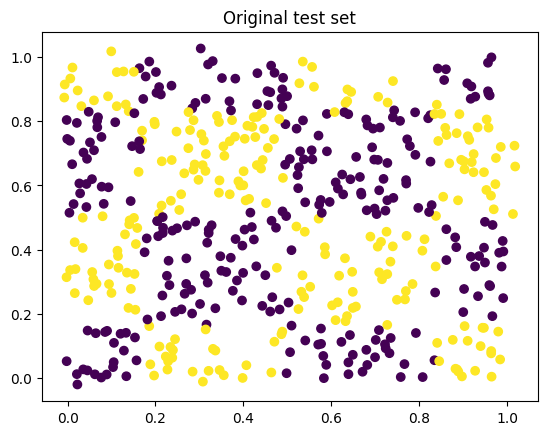

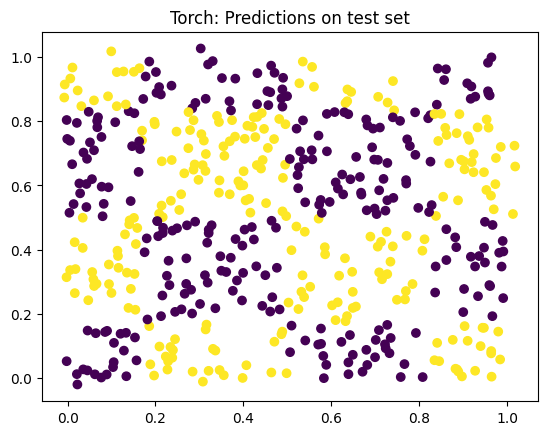

In [8]:
torch_model.eval()
# pylint: disable=not-callable
fp32_pred = torch_model(torch.tensor(X_test).float()).argmax(1).float().detach().numpy()
# pylint: enable=not-callable

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.astype(numpy.float64))
plt.title("Original test set")
plt.show()

plt.scatter(X_test[:, 0], X_test[:, 1], c=fp32_pred)
plt.title("Torch: Predictions on test set")
plt.show()

### Import and test the quantization aware trained model in Concrete-ML

Note that the model will have float inputs and outputs in torch, but the inputs and outputs will
need additional quantization in Concrete-ML. This may lower the accuracy depending on the input and output quantizers.
In this example we used 7 bits for network inputs and outputs, which shows a negligeable loss  
of accuracy (~0.2 percentage points) for this dataset. 

Max bitwidth: 8 bits -> it works in FHE!!
Test Quantized Accuracy: 95.60%


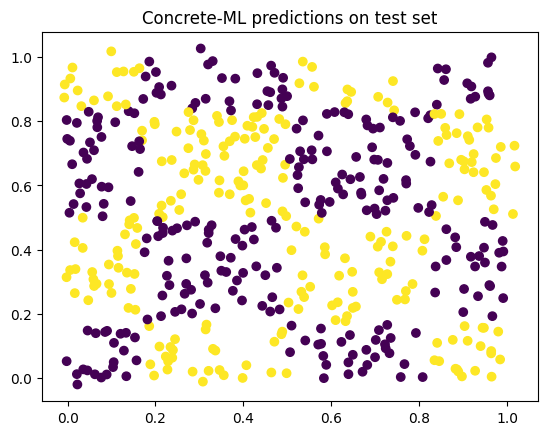

In [9]:
import warnings

with warnings.catch_warnings():
    # Disable some brevitas export warnings
    warnings.filterwarnings("ignore")
    _, _, clear_prediction = compile_and_test(torch_model, X_train, X_test, y_test, is_qat=True)

plt.scatter(X_test[:, 0], X_test[:, 1], c=fp32_pred)
plt.title("Concrete-ML predictions on test set")
plt.show()

### Conclusion

In this notebook we showed how to implement a quantization aware training neural network with brevitas.
We showed that using QAT and pruning we can obtain good accuracy while training is robust, i.e. the network trains
well with different random initializations, optimizer and hyperparameter settings. 

The accuracy of the QAT network in FHE is ~94.5%. QAT networks have the same accuracy between their
float torch versions and their integer **Concrete-ML** FHE versions. Note that a network with similar 
topology to the one implemented here, trained in floating point with no QAT, 
and quantized post-training, obtains only 58% accuracy.

